# First pass at EDA after data migrated to Postgres
28 September 2017

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import re
from dateutil.parser import parse
import spacy
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence
from dateutil.relativedelta import relativedelta

%matplotlib inline

In [48]:
df = pd.read_pickle('../data/postgres_db.pkl')
df['word_count'] = [len(x.split()) if x is not None else 0 for x in df.body]

In [49]:
to_update = []

In [82]:
weird_dates = df[(df.pub_time < pd.Timestamp.min) | (df.pub_time > datetime.datetime.now())]
to_update.append(weird_dates.url)
df.loc[weird_dates.index,'pub_time'] = None

In [83]:
df.loc[weird_dates.index,'pub_time']

655       None
830       None
857       None
1414      None
3234      None
4441      None
4570      None
4803      None
5288      None
5393      None
7547      None
8866      None
10034     None
12052     None
13031     None
13188     None
13231     None
15286     None
15409     None
15594     None
16127     None
16795     None
17198     None
17269     None
17510     None
18417     None
19085     None
19656     None
21386     None
21403     None
          ... 
244592    None
244732    None
248114    None
250036    None
250636    None
251188    None
251378    None
251685    None
251944    None
252564    None
255326    None
255963    None
256259    None
256941    None
257049    None
257561    None
257680    None
258172    None
258715    None
258772    None
259371    None
259771    None
260081    None
260659    None
261617    None
262793    None
263698    None
263790    None
265061    None
265152    None
Name: pub_time, Length: 364, dtype: object

In [51]:
def url_regex(i, df):
    date = re.findall('/(\d{4}/\d{2}/\d{2})', df.loc[i]['url'])
    if date:
        df.loc[i,'pub_time'] = parse(date[0])

In [52]:
null_dates = df[df.pub_time.isnull()]
to_update.append(null_dates.url)
for i, row in null_dates.iterrows():
    url_regex(i, df)

In [84]:
crazy_dates = df[df.pub_time < datetime.datetime(1990, 1, 1)]
to_update.append(crazy_dates.url)
df.loc[crazy_dates.index,'pub_time'] = None
# for i, row in crazy_dates.iterrows():
#     url_regex(i, df)
#     test_year = df.loc[i,'pub_time'] + relativedelta(years=100).year
#     if (test_year > 2000) and (test_year < datetime.datetime.now().year):
#         df.loc[i,'pub_time'] = datetime.datetime(test_year.year, 
#                                                  df.loc[i,'pub_time'].month, 
#                                                  df.loc[i,'pub_time'].day)
#     else:
#         df.loc[i,'pub_time'] = None

In [85]:
df = df[(df.pub_time).notnull()]

In [86]:
len(df)

306864

In [87]:
min_date = min(df.pub_time).date()
max_date = max(df.pub_time).date()
print(min_date, max_date)

2000-01-01 2017-10-01


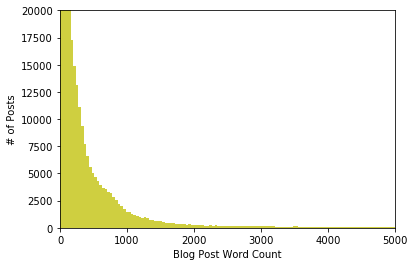

In [89]:
plt.axis([0, 5000, 0, 20000])
plt.xlabel('Blog Post Word Count')
plt.ylabel('# of Posts')
# plt.grid(True)
plt.hist(df.word_count, 10000, facecolor='y', alpha=0.75);

In [135]:
avg_word_count = df.groupby('blog_url').mean()
avg_word_count.sort_values(by='word_count',ascending=True, inplace=True)
aggregagtors = avg_word_count[avg_word_count['word_count'] < 200]

In [140]:
df = df[df.blog_url.isin(aggregagtors.index) == False]

In [141]:
len(df)

151014

In [142]:
grouped = df.groupby('blog_url').count()
grouped.reset_index(inplace=True)
grouped.rename(columns={'url':'post_count'},inplace=True)
grouped = pd.concat([grouped.blog_url, grouped.post_count], axis=1)
grouped.sort_values(by='post_count',ascending=False, inplace=True)
grouped.reset_index(inplace=True, drop=True)

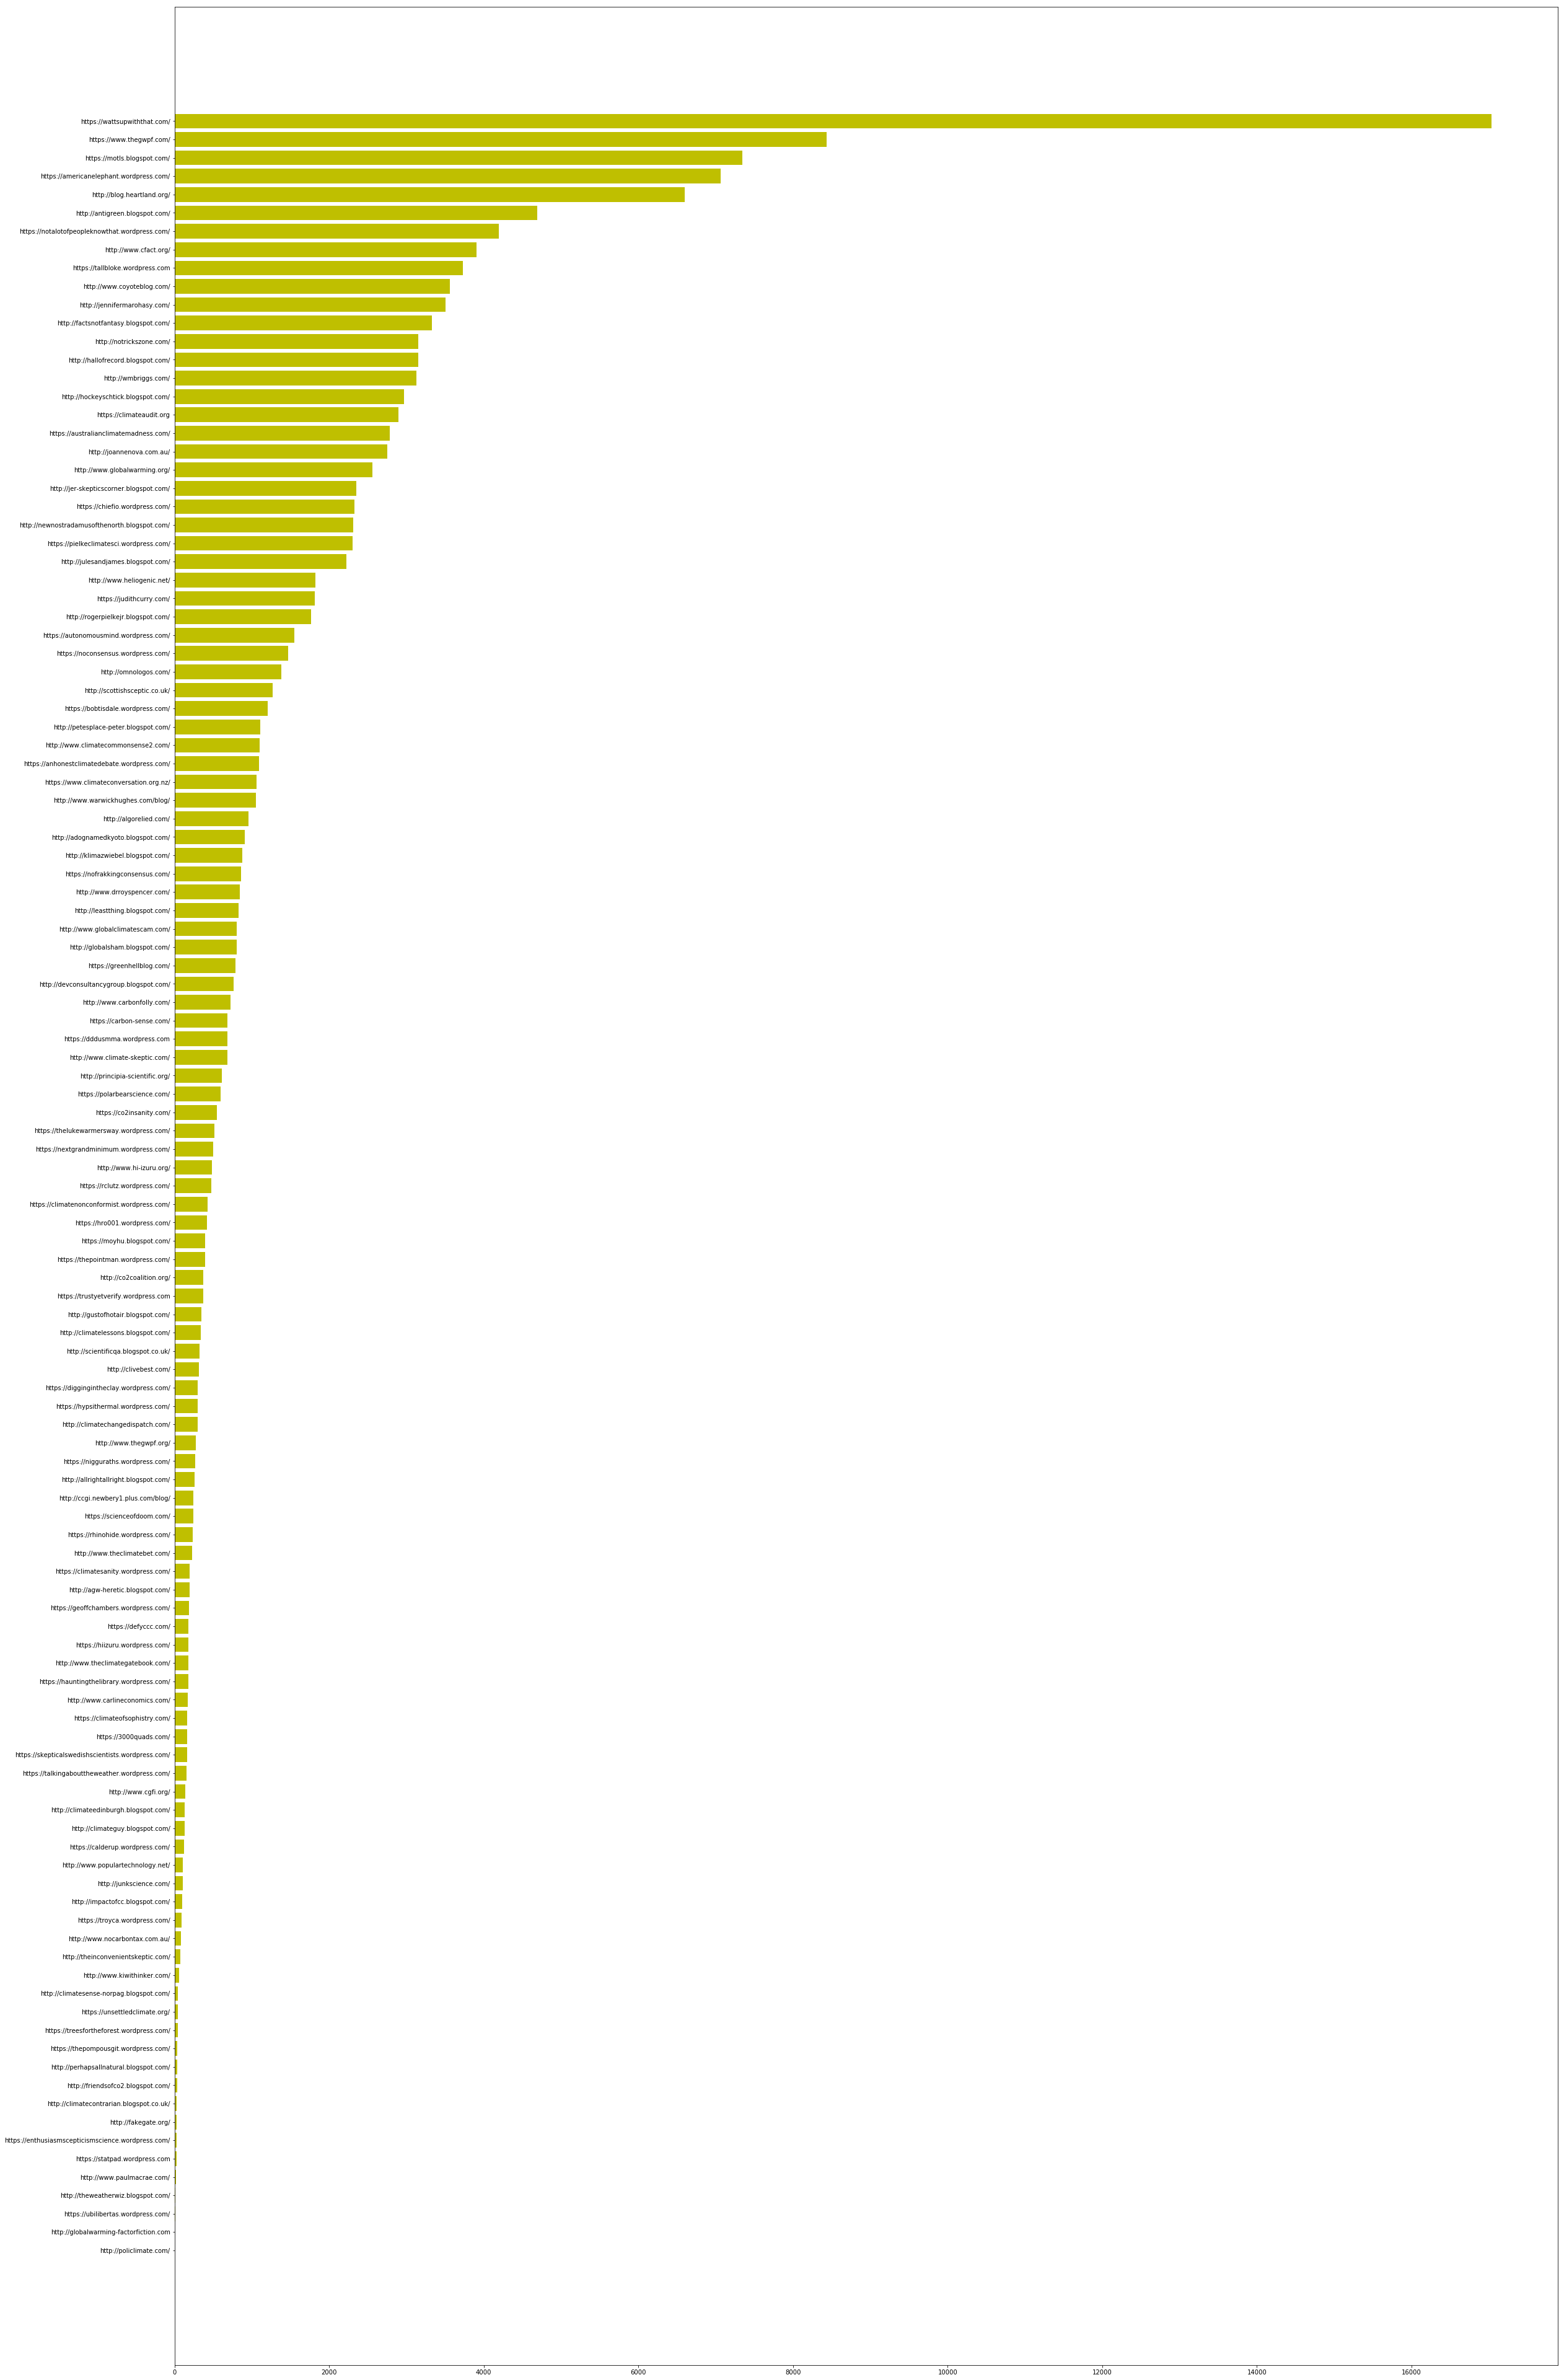

In [143]:
fig, ax = plt.subplots(figsize=(40, 70))
rects2 = ax.barh(grouped.index, grouped.post_count, color='y');
ax.set_yticks(grouped.index)
ax.set_yticklabels(grouped.blog_url);
ax.invert_yaxis()  # labels read top-to-bottom

In [144]:
ix = pd.DatetimeIndex(start=min_date, end=max_date, freq='M')

def compile_monthly(blog_url, df):
    blog_posts = df[df.blog_url == blog_url]
    blog_posts = blog_posts.set_index(pd.DatetimeIndex(blog_posts['pub_time']))    
    blog_posts = blog_posts.resample('M').count()['url']
    blog_posts = blog_posts.reindex(ix, fill_value=0)
    return blog_posts.values

In [183]:
blogs_to_plot = df[df.blog_url.isin(grouped[0:12]['blog_url'])]
blog_start_date = blogs_to_plot.groupby('blog_url').agg('min')
blog_start_date.sort_values(by='pub_time',ascending=True, inplace=True)
blog_start_date.reset_index(inplace=True)

In [184]:
posts = []
for blog_url in blog_start_date.blog_url:
    posts.append(compile_monthly(blog_url, df))

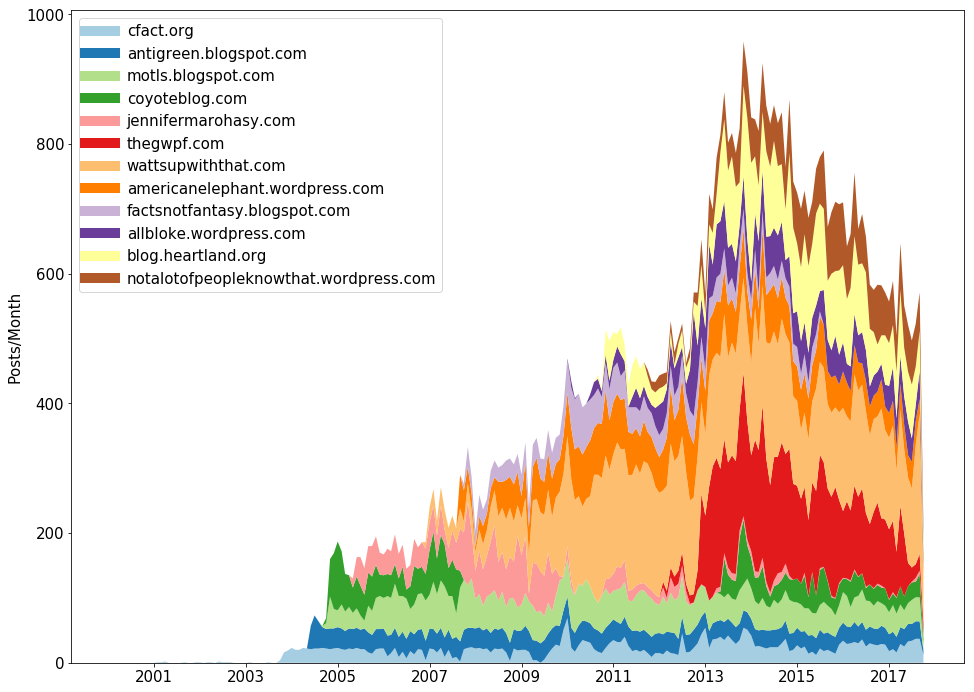

In [186]:
color_list = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']

fig, ax = plt.subplots(figsize=(16,12));
ax.stackplot(ix, posts[0:12], colors = color_list);

for i in range(12):
    label = blog_start_date.loc[i]['blog_url'].strip('https://')
    label = label.replace('www.','')
    plt.plot([],[],color=color_list[i], label=label,linewidth=10)

    
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=15)
plt.ylabel('Posts/Month', fontsize=15)
plt.legend(loc='upper left', fontsize=15)

In [191]:
blog_posts = df[df.blog_url == 'http://www.coyoteblog.com/']

In [196]:
newer_posts = blog_posts[blog_posts.pub_time < datetime.datetime(2012, 1, 1)]

In [197]:
newer_posts[newer_posts.pub_time == max(newer_posts['pub_time'])]['url']

156809    http://www.coyoteblog.com/coyote_blog/2007/08/...
Name: url, dtype: object

In [198]:
newer_posts.loc[156809]['url']

'http://www.coyoteblog.com/coyote_blog/2007/08/a-thought-on-bl.html'